In [1]:
from pathlib import Path

import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from tqdm import tqdm  # For progress bars

from handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [2]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"

DETECTOR = 100
N_PLANCK_SIMS = 100

NSIDE = 512

In [3]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

# Setup

In [4]:
def plot_ps(ps,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            white_noise_expected=None):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    plt.plot(ps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--')
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.show()

In [5]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        if styles is None:
            style = None
            linewidth = 1
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        label = None if labels is None else labels[i]
        plt.plot(ps, label=label, linestyle=style, linewidth=linewidth)
    if white_noise_expected is not None:
        plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
        plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
                 color='black',
                 horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [6]:
def make_map_hist(some_map, noise_level, title=None, legend=False):
    if isinstance(some_map, list):
        for i, one_map in enumerate(some_map):
            label = f"Map {i}" if legend else None
            plt.hist(one_map, bins=100, histtype='step', label=label)
    else:
        plt.hist(some_map, bins=100, histtype='step')
    plt.axvline(noise_level, color='black', linestyle='--', linewidth=1)
    plt.axvline(-noise_level, color='black', linestyle='--', linewidth=1)
    plt.text(x=-noise_level, y=175000, s=f"$-\\sigma$", color='black', 
            rotation=90,
            verticalalignment='center', horizontalalignment='right')
    offset = transforms.ScaledTranslation(2/72, 0, plt.gcf().dpi_scale_trans)
    plt.text(x=noise_level, y=175000, s=f"$+\\sigma$", color='black', 
            rotation=90,
            verticalalignment='center', horizontalalignment='left',
            transform=plt.gca().transData + offset)
    plt.xlabel("$\\mu K_{CMB}$")
    plt.ylabel("Pixel Count")
    if legend:
        plt.legend()
    plt.title(title)

# Planck Sims

In [7]:
lmax = get_lmax_for_nside(NSIDE)  # Defined above as 3*Nside-1

In [8]:
# Pre-download
for i in range(N_PLANCK_SIMS):
    src_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=i, progress=True)
print("All maps acquired!")

All maps acquired!


In [9]:
src_cls = []
for i in tqdm(range(N_PLANCK_SIMS)):
    src_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=i, progress=True)
    t_src_map = hp.read_map(src_map_fn) * 1e6
    src_cls.append(hp.anafast(t_src_map, lmax=lmax))
del t_src_map

100%|██████████| 100/100 [14:33<00:00,  8.74s/it]


In [10]:
ps_means = [np.mean(src_cls[:i], axis=0) for i in range(1, N_PLANCK_SIMS)]
ps_std = [np.std(src_cls[:i], axis=0) for i in range(1, N_PLANCK_SIMS)]

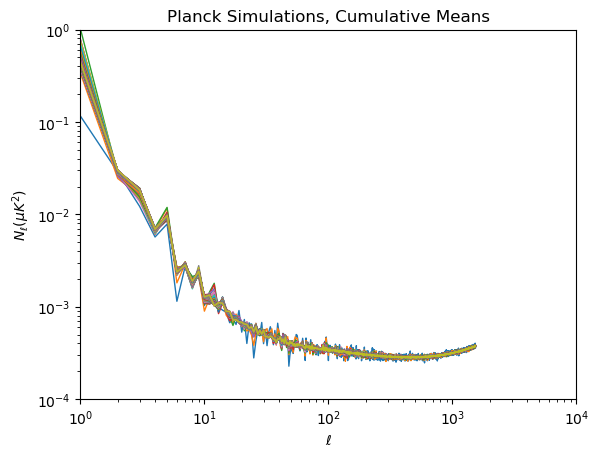

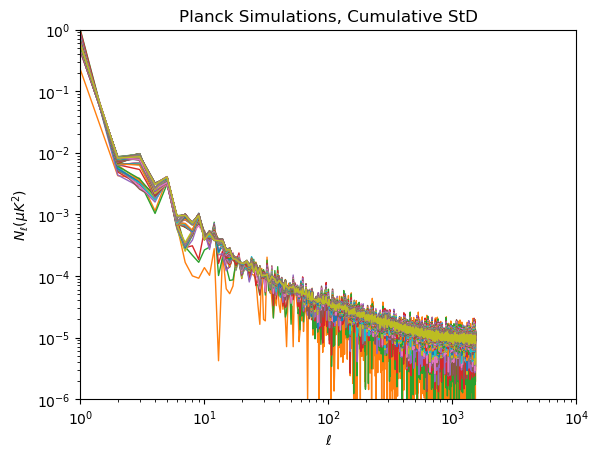

In [11]:
plot_many_ps(ps_means[:], y_high=1, 
             title="Planck Simulations, Cumulative Means", 
             legend=False)
plot_many_ps(ps_std[:], y_high=1, y_low=1e-6, 
             title="Planck Simulations, Cumulative StD", 
             legend=False)


In [12]:
# We find that after 40 simulations, the power spectrum is "stable"
guess_n_to_use = 40

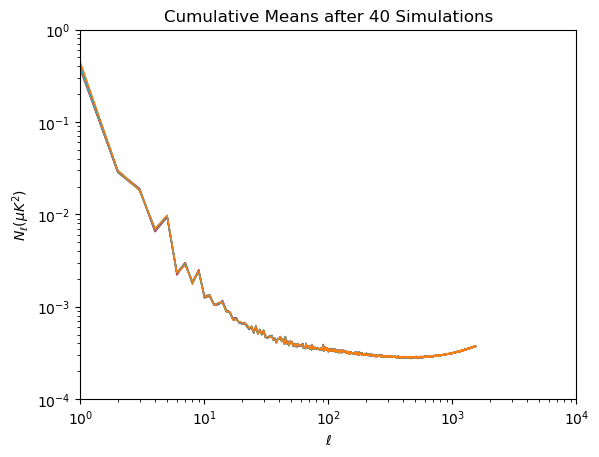

In [13]:
# Compare cumulative mean power spectra; converges to the expected white noise level

mean_title = f"Cumulative Means after {guess_n_to_use} Simulations"
# plot_many_ps(ps_means[guess_n_to_use:guess_n_to_use+11:5], 
#              y_high=1, x_low=0.99, x_high=lmax_128, 
#              title=mean_title, 
#              labels=[1, 2, 3, 4],   # Up to 4 as a dummy check to ensure I'm not plotting too many
#              legend=True)
plot_many_ps(ps_means[guess_n_to_use::5], y_high=1, title=mean_title, legend=False)
# plot_many_ps(ps_means[40::5], y_high=1e-3, x_low=10, x_high=380, title=mean_title, legend=False)

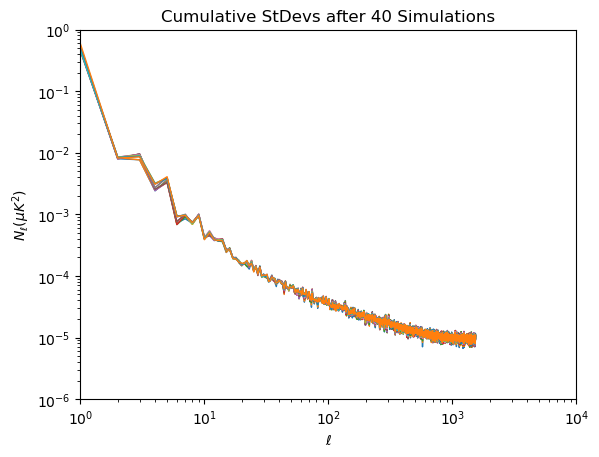

59


In [14]:
stdev_title = f"Cumulative StDevs after {guess_n_to_use} Simulations"
plot_many_ps(ps_std[guess_n_to_use::5], y_high=1, y_low=1e-6, title=stdev_title, legend=False)
print(len(ps_std[guess_n_to_use:]))